# Data Storytelling

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

## Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

## Cleaning steps

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher


In [11]:
# Extract the year from the datetime object and create a new column "year"
temp_county['year'] = [date[:4]
 for date in temp_county.loc[:,'dt']]

In [12]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [13]:
disaster_county = disaster_df.copy()

In [14]:
# Extract the year from the datetime object and create a new column "Year"
disaster_county['Year'] = [date[-4:]
 for date in disaster_county.loc[:,'Declaration Date']]

In [15]:
# group by year county name and year
avg_year_temp = temp_county.groupby(['countyname','year']).mean().reset_index()

In [16]:
# left join on county and year
join_county = pd.merge(disaster_county, avg_year_temp, how='left', left_on=['County','Year'], right_on=['countyname','year'])
join_county.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,countyname,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#join_county.info()

With this join, a lot of columns were lost in the temperature dataframe, so I will try to join on state instead of county. 

In [18]:
# temperature data grouped by state and year
dftemp1 = temp_county.copy()
dftemp2 = dftemp1.groupby(['state','year'], as_index=False).mean()

In [19]:
# disaster data, creating a new column with just the year, taken from the declaration date
dfdisaster1 = disaster_df.copy()
dfdisaster1['Year'] = [date[-4:]
 for date in dfdisaster1.loc[:,'Declaration Date']]

In [20]:
# left join on the disaster data, joined on state and year
join_state = pd.merge(dfdisaster1, dftemp2, how='left', left_on=['State','Year'], right_on=['state','year'])
join_state_1 = join_state[['Declaration Number','Declaration Date','State','state','Year','year','AverageTemperature']]
join_state.dropna().head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,state,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n
89,DR-91,Disaster,01/29/1959,IN,Clay County,Flood,Flood,01/29/1959,01/29/1959,11/01/1960,...,No,Yes,Yes,1959,IN,1959,10.942726,0.279107,40.53000,-86.154286
181,DR-183,Disaster,12/24/1964,CA,Alpine County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
182,DR-183,Disaster,12/24/1964,CA,Amador County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
183,DR-183,Disaster,12/24/1964,CA,Butte County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
184,DR-183,Disaster,12/24/1964,CA,Colusa County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871


The number of rows that were able to be joined was much higher at the state level than at the county level. This makes sense, as the county names are specific, but when analyzing the data, seeing trends at the region or state level should be sufficient. The following code verifies that the missing joins is a result of some missing information of the temperature data frame. The dates do not go past 2013 and there are only 35 states available. Once those values were omitted, there were no more rows that did not join; thus it is safe to drop the null values.

In [45]:
# check the null values; determine that they are because of the missing state and date data from the temperature data frame
df1 = join_state[join_state['AverageTemperature'].isnull()]
#df1.info()

In [46]:
df2 = df1[df1['Year']<='2013']
#df2.info()

In [23]:
states_limited = temp_county['state'].drop_duplicates().tolist()
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
states_remove = [state for state in states if state not in states_limited]

In [24]:
df3 = df2[df2['State'].isin(states_limited)]
df3

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,state,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n


## Further Data Cleaning Steps

The following steps provide extra information in the data, simplifying and extracting the necessary information so that it is ready to be used for data visualization.

In [25]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County


In [26]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = [date[5:7]
 for date in temp_county.loc[:,'dt']]

In [27]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [28]:
# Assign United States common regions to the states
east_north_central_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_region, 'east north central region')

west_north_central_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_region, 'west north central region')

new_england_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_region, 'new england region')

pacific_region = ['AK','OR','WA','CA','HI']
d4 = dict.fromkeys(pacific_region, 'pacific region')

west_south_region = ['AR','LA','OK','TX']
d5 = dict.fromkeys(west_south_region, 'west south region')

east_south_region = ['AL','MS','TN','KY']
d6 = dict.fromkeys(east_south_region, 'east southeast region')

mountain_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d7 = dict.fromkeys(mountain_region, 'mountain region')

midatlantic_region = ['NY','PA','NJ']
d8 = dict.fromkeys(midatlantic_region, 'midatlantic region')

south_atlantic_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_region, 'south atlantic region')


In [29]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname,month,season,region
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,1,Winter,west south region
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,2,Winter,west south region
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,3,Spring,west south region
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,4,Spring,west south region
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,5,Spring,west south region


## Exploring the Data

#### The main hypothesis is: 
How does temperature change affect the other natural processes in the world? More specifically, how are natural disasters changing, due to global warming?

To start, I will look at the temperature dataframe and see how the temperature changes with time and with location.

### Average yearly temperature, sorted by state

The first question to examine is how temperature in the United States is changing over time. We can plot the average yearly temperature over time, for each of the states we have data for. In the case where there were multiple counties in each state, the average temperature for all of the counties was taken, resulting in one value per year per state.

Text(0,0.5,'Temperature (in degrees Celsius)')

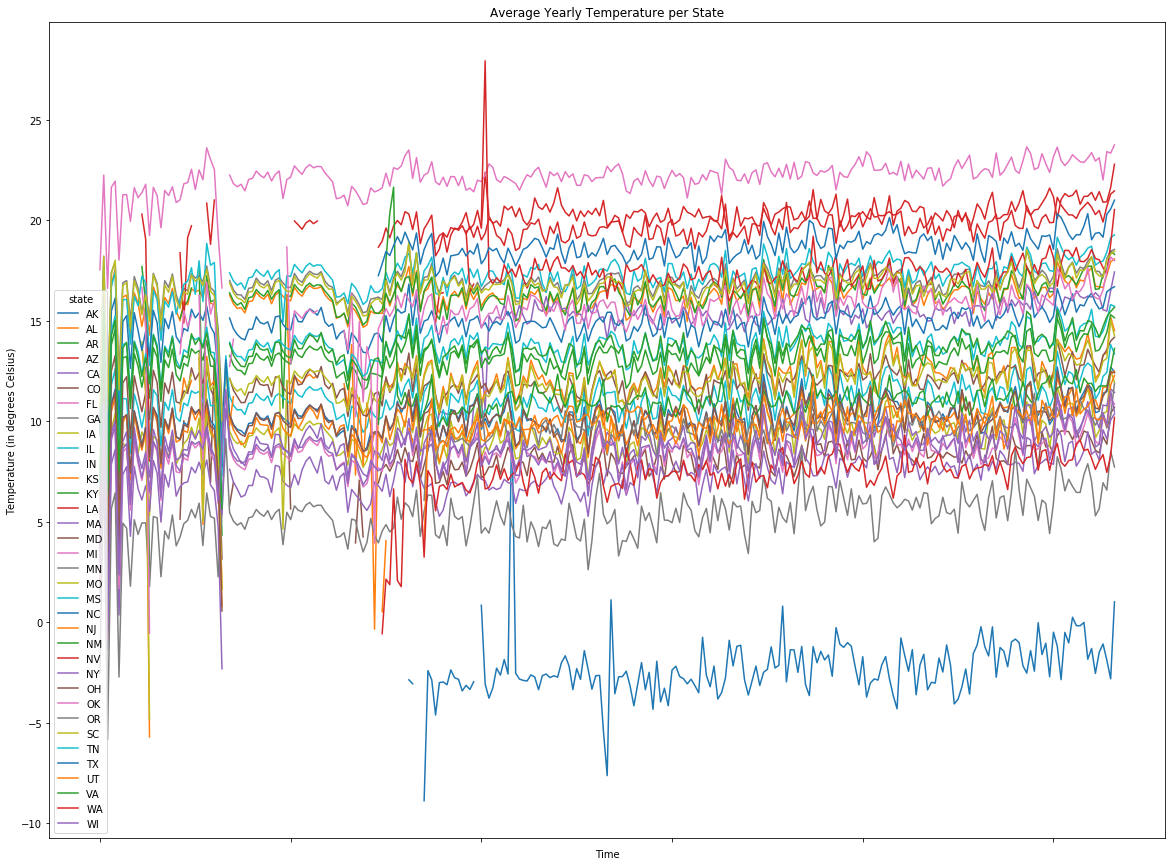

In [30]:
# plot data: average yearly temperature by state
fig, ax = plt.subplots(figsize=(20,15))
temp_county_region.groupby(['year','state']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average Yearly Temperature per State')
plt.xlabel('Time')
plt.ylabel('Temperature (in degrees Celsius)')

Text(0,0.5,'Temperature (in degrees Celsius)')

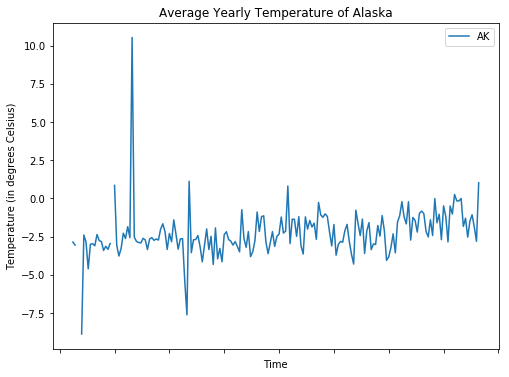

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
temp_county_region.groupby(['year','state']).mean()['AverageTemperature'].unstack().plot(y='AK',ax=ax)
plt.title('Average Yearly Temperature of Alaska')
plt.xlabel('Time')
plt.ylabel('Temperature (in degrees Celsius)')

At a glance, there are definite trends in the data; however this visualization is too overwhelming to make meaningful insights. A deeper look at the values will gives us more insight as to what is happening with the temperature values. There is a clear outlier, or a state with relatively low temperatures, which was the state of Alaska. A graphical check  confirms that Alaska was the state with the low values. This appears normal, given the geographical location of Alaska, being further away from the equator than other states.

Next, I want to explore how much temperature is changing over time. I will examine the minimum, maximum, and largest difference for the average temperature, and I will sort based on state and region.

In [32]:
# temperature data grouped by state and year
state_year_temperature = temp_county_region.groupby(['state','year']).mean()['AverageTemperature'].unstack()
state_year_temperature['min'] = state_year_temperature.min(axis=1)
state_year_temperature['max'] = state_year_temperature.max(axis=1)
state_year_temperature['difference'] = state_year_temperature['max'] - state_year_temperature['min']
#state_year_temperature.head()

Text(0,0.5,'Temperature (in degrees Celsius)')

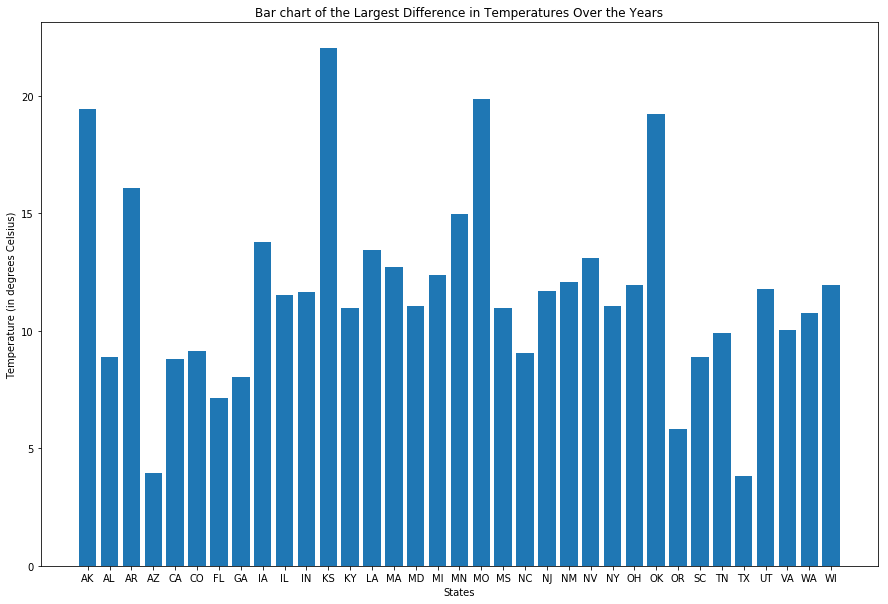

In [33]:
# Bar chart of the largest difference in temperatures over the years
fig, ax = plt.subplots(figsize=(15,10))
state_year_temperature_graph = state_year_temperature.reset_index()
state_year_temperature_graph = state_year_temperature_graph[['state','min','max','difference']]
plt.bar(state_year_temperature_graph['state'], state_year_temperature_graph['difference'])
plt.title('Bar chart of the Largest Difference in Temperatures Over the Years')
plt.xlabel('States')
plt.ylabel('Temperature (in degrees Celsius)')

This graphical display shows the difference between the lowest minimum and the highest maximum  This provides some insight as to which states have experienced great change over time,This graphical display shows the difference between the lowest minimum and the highest maximum for each state. This provides some insight as to which states have experienced great change over time, and which states, such as TX and AZ, have remained relatively constant. One drawback is that there is no telling which year the maximum and minimum value came from, so it is not the best representation of temperature change over time, but it does give us an idea of which states experience greater changes in temperature. and which states, such as TX and AZ, have remained relatively constant.

Text(0,0.5,'Temperature (in degrees Celsius)')

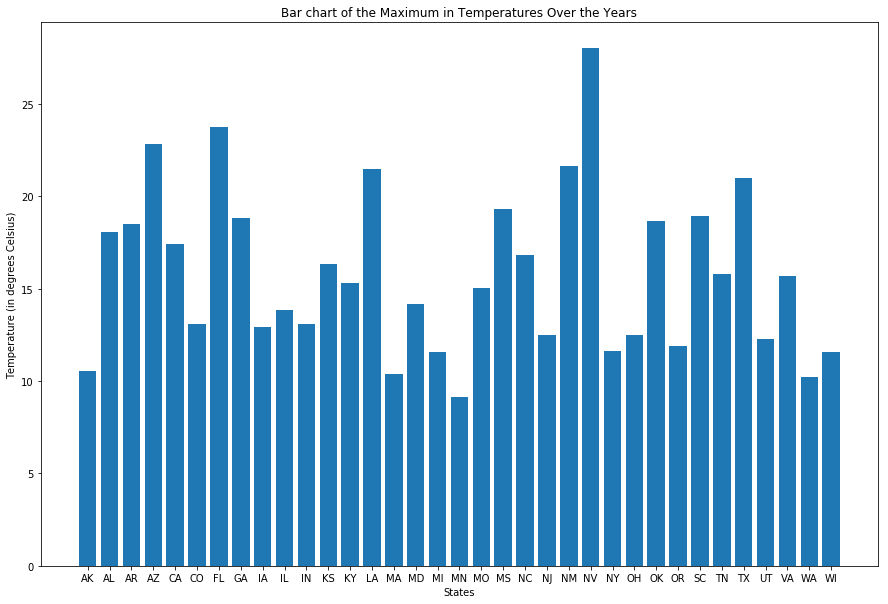

In [34]:
# Bar chart of the maximum temperatures per year
fig, ax = plt.subplots(figsize=(15,10))
state_year_temperature_graph = state_year_temperature.reset_index()
state_year_temperature_graph = state_year_temperature_graph[['state','min','max','difference']]
plt.bar(state_year_temperature_graph['state'], state_year_temperature_graph['max'])
plt.title('Bar chart of the Maximum in Temperatures Over the Years')
plt.xlabel('States')
plt.ylabel('Temperature (in degrees Celsius)')

This graph portrays the maximum temperature value that the state experienced of all time. This information is useful to know which states generally have high temperatures and which are relatively low. The highest temperature recorded within this dataframe was in NV and the state with the lowest maximum temperature is MN. Again, there is the limitation that the year is unknown. 

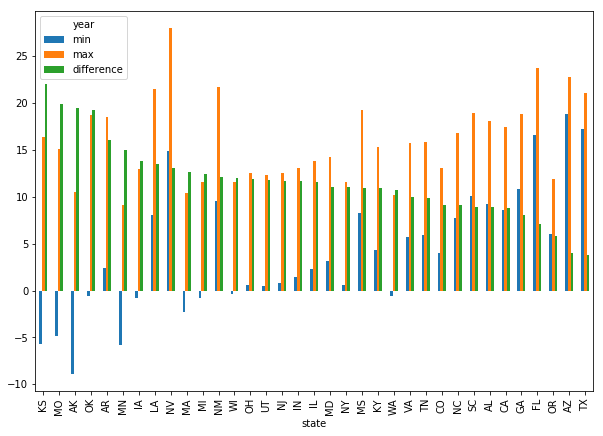

In [48]:
# grouped bar chart of the min and max temperatures in a given region
df = state_year_temperature.iloc[:,-3:]
df = df.sort_values('difference', ascending=False)
df.plot.bar(figsize=(10,7))
plt.show()

This graph shows the minimum, maximum and difference values for the states; it is more clear to show which states had the greatest change in temperature. It can be noted that just because a state has the highest maximum (NV), that does not indicate that it has the greatest change overall. This is a good insight to consider when determining what it means to have the greatest increase in temperature, because basing it off the maximum temperature can be misleading.

I will now explore the same graphs - largest difference, maximum, and the combination of the max, min, and difference - with the regions as the groups, instead of state. The reasoning behind choosing regions to group the data by is that regional groupings are more based on geographical location, not state lines. Also, thinking about where natural disasters occur, they are not limited by state lines, but rather they occur in certain climates and biomes.

In [36]:
# temperature data grouped by region and year
region_year_temperature = temp_county_region.groupby(['region','year']).mean()['AverageTemperature'].unstack()
region_year_temperature['min'] = region_year_temperature.min(axis=1)
region_year_temperature['max'] = region_year_temperature.max(axis=1)
region_year_temperature['difference'] = region_year_temperature['max'] - region_year_temperature['min']
#region_year_temperature

Text(0,0.5,'Temperature (in degrees Celsius)')

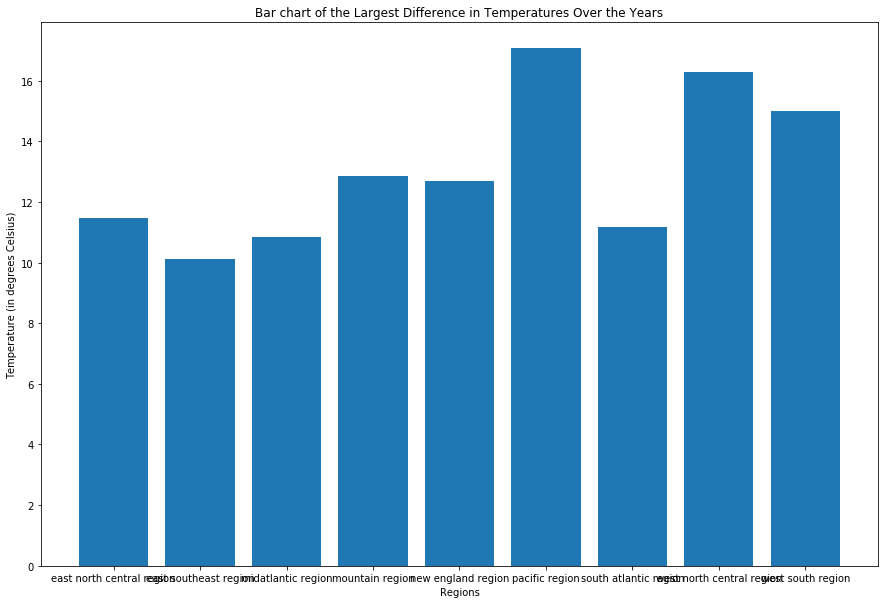

In [65]:
# Bar chart of the largest temperature difference
fig, ax = plt.subplots(figsize=(15,10))
region_year_temperature_graph = region_year_temperature.reset_index()
region_year_temperature_graph = region_year_temperature_graph[['region','min','max','difference']]
plt.bar(region_year_temperature_graph['region'], region_year_temperature_graph['difference'])
plt.title('Bar chart of the Largest Difference in Temperatures Over the Years')
plt.xlabel('Regions')
plt.ylabel('Temperature (in degrees Celsius)')

Text(0,0.5,'Temperature (in degrees Celsius)')

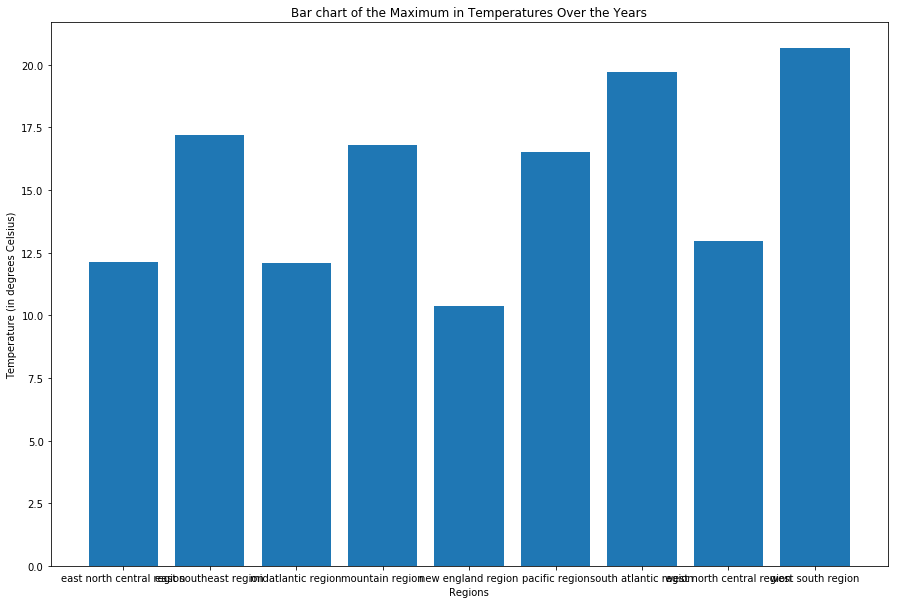

In [64]:
# Bar chart of the maximum temperatures per year
fig, ax = plt.subplots(figsize=(15,10))
region_year_temperature_graph = region_year_temperature.reset_index()
region_year_temperature_graph = region_year_temperature_graph[['region','min','max','difference']]
plt.bar(region_year_temperature_graph['region'], region_year_temperature_graph['max'])
plt.title('Bar chart of the Maximum in Temperatures Over the Years')
plt.xlabel('Regions')
plt.ylabel('Temperature (in degrees Celsius)')

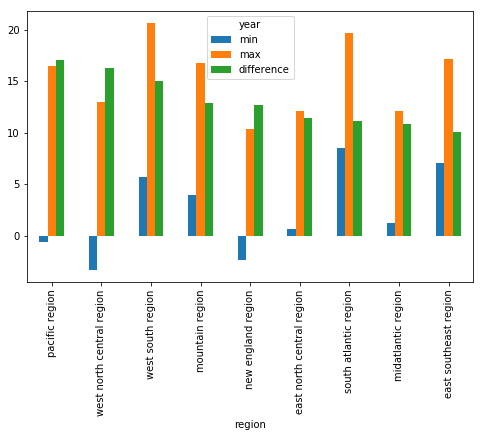

In [50]:
# grouped bar chart of the min and max temperatures in a given region
df1 = region_year_temperature.iloc[:,-3:]
df1 = df1.sort_values('difference', ascending=False)
df1.plot.bar(figsize=(8,5))
plt.show()

Sorting by regions, there is a more concise view, and it can be noted that the pacific region has the largest difference, even though the west south region has the largest maximum temperature. This shows that analyzing based on the difference versus the maximum value may result in a different conclusion. Since I want to analyze the change in temperature from the first recorded date to the most recent, I will filter the data to plot that data. 

In [72]:
# obtain the first (oldest) and last (most recent) temperature value for each state
first_last = temp_county_region.copy()
first_last = first_last[['state','year','AverageTemperature']]
first_last = first_last.groupby('state').AverageTemperature.agg(['first', 'last'])

In [80]:
first_last['difference'] = first_last['last'] - first_last['first']
first_last.reset_index().head()

,state,first,last,difference
0,AK,-17.738,11.182,28.920
1,AL,10.572,25.281,14.709
2,AR,10.770,25.499,14.729
3,AZ,11.544,24.601,13.057
4,CA,13.116,23.301,10.185


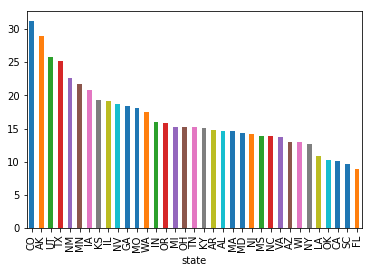

In [90]:
first_last['difference'].sort_values(ascending=False).plot.bar()
plt.show()

I will also look at the seasons (Spring, Summer, Fall, Winter) to see how temperature is changing depending on the time of year.

In [40]:
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname,month,season,region
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,1,Winter,west south region
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,2,Winter,west south region
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,3,Spring,west south region
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,4,Spring,west south region
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,5,Spring,west south region


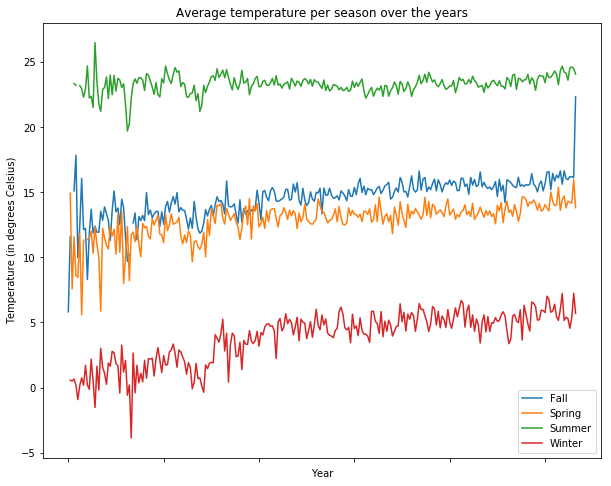

In [41]:
# temperature over time by season
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','season']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per season over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

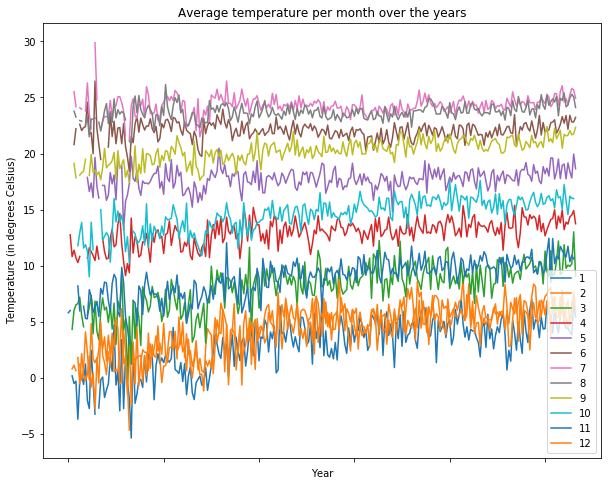

In [42]:
# temperature over time by month
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','month']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per month over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

In [43]:
temp_county_region.groupby(['region','year']).mean().loc['central region'].head()

KeyError: 'the label [central region] is not in the [index]'

In [ ]:
# percent change from the previous year: central region
temp_county_pct_change = temp_county_region.groupby(['region','year']).mean()
temp_county_pct_change = temp_county_pct_change.pct_change()
temp_county_pct_change.loc['central region'].iloc[:,:1].plot()

In [ ]:
# percent change from the previous year: south region
temp_county_pct_change.loc['south region'].iloc[:,:1].plot()

In [ ]:
df1 = temp_county_region.groupby(['region','year']).mean().iloc[:,:1].unstack().T
df1.head()

In [ ]:
df2 = df1.reset_index().set_index('year').drop(columns='level_0')
df2.head()

In [ ]:
# regional temperature change over time
df2.plot()

In [ ]:
dataframe1 = temp_county_region.groupby(['region','year']).mean().iloc[:,:1].unstack().T
dataframe1 = temp_county_region.groupby(['region','year'], as_index=False).mean()
dataframe1

In [ ]:
dataframe1[dataframe1['region'] == 'central region'].AverageTemperature.idxmax()

In [ ]:
dataframe1[dataframe1['region'] == 'central region'].

In [ ]:
df_central = dataframe1.loc['central region']
print('min year = ', df_central['AverageTemperature'].idxmin(), ', max year = ', df_central['AverageTemperature'].idxmax())